# Survival Analysis

In [2]:
from awpy import Demo

# folder of demos
path = ".demos/"

# match one between Faze and Cloud 9 in the Perfect World Shanghai RMR for 4th place
# accessed via https://www.hltv.org/matches/2377025/match
match = "faze-vs-cloud-9-m1-mirage.dem"

# load demo
dem = Demo(path + match)

Things that I would like to do:
1. Build a Kaplan-Meier curve
    * Overall and by team
2. Accelerated Failure Time model
    * Find factors that extend a players time until elimination
3. Cox Proportional Hazard model
    * Find factors taht decrease risk of elimination

Factors that seem important right now:
* Guns bought
* Armor / helmet
* Economy prior to round start
* Position
* Damage taken
* Kills in the round
* Bomb status

## Kaplan Meier

Some things I need: 
* acculumated time each player was alive in a round
* key to distinguish: team name / side (T or CT)

In [131]:
rounds = dem.rounds

# creating how long a player could be alive for on a given round
rounds['round_length'] = dem.rounds['official_end'] - dem.rounds['freeze_end']
rounds['round_length_seconds'] = rounds['round_length']/64

# rounds[['round', 'round_length_seconds']]

In [ ]:
import pandas as pd
import numpy as np

kills = dem.kills

# grab victim name and ticks since round start
# this will not have everyone 
# but create list general list of every player for every round
# then if they don't have a time they will be censored
base_info = dem.events['player_team'][['user_name', 'user_team_clan_name']]

# record of when people are eliminated
death_info = kills[['victim_name', 'victim_team_name',  'round' ,'ticks_since_round_start']].rename(columns = {'victim_name':'user_name'})


# simple function to repeat the base information as many times as there are rows
def repeat_dataframe(df, n):
    return pd.concat([df] * n, ignore_index=True)


# repeat all players 19 times
blank_info = repeat_dataframe(base_info, dem.rounds.shape[0]) 

# create round for each
blank_info['round'] = np.concatenate([([i]*10) for i in range(1, 20)], axis=0) 

# set index for easy indexing
blank_info = blank_info.set_index(['round', 'user_name'])
death_info = death_info.set_index(['round', 'user_name'])

# join death information onto blank info
survival_info = blank_info.join(death_info)

# create time in seconds
survival_info['seconds'] = survival_info['ticks_since_round_start']/64

# censor information
# if there is NOT a time, then they survived and are a 0
survival_info['died'] = np.select(
    [
        survival_info['seconds'].isna()
    ],
    [
        False
    ],
    default = True
)


# kaplan meier can't deal with missing values so set them to official end
# # Merge the tables on the 'round' column
merged_table = survival_info.reset_index().merge(rounds, on='round', how='left')

# # Fill NA values in 'seconds' with 'round_length'
merged_table['seconds'] = merged_table['seconds'].fillna(merged_table['round_length_seconds'])

survival_data = merged_table[['round', 'user_name', 'user_team_clan_name', 'victim_team_name', 'seconds', 'died']]

,round,user_name,user_team_clan_name,victim_team_name,seconds,died
0,1,HeavyGod,Cloud 9,TERRORIST,85.515625,True
1,1,Ax1Le,Cloud 9,TERRORIST,84.734375,True
2,1,interz,Cloud 9,TERRORIST,56.375,True
3,1,Boombl4,Cloud 9,TERRORIST,77.34375,True
4,1,ICY,Cloud 9,TERRORIST,55.84375,True
...,...,...,...,...,...,...
185,19,ropz,FaZe Clan,NaN,62.765625,False
186,19,frozen,FaZe Clan,NaN,62.765625,False
187,19,rain,FaZe Clan,TERRORIST,110.5,True
188,19,karrigan,FaZe Clan,TERRORIST,120.765625,True


Text(0.5, 0, 'time $t$')

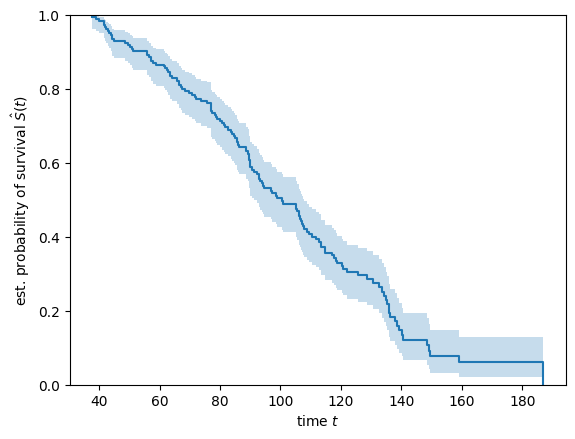

In [145]:
import matplotlib.pyplot as plt

from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob, conf_int = kaplan_meier_estimator(
    survival_data["died"], survival_data["seconds"], conf_type="log-log"
)

plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")